In [74]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
df = pd.read_csv('buyer_cuisine_training_data.csv')

In [8]:
df=df.drop(columns='Unnamed: 0')

In [13]:
df.columns

Index(['buyer_id', 'items', 'buyer_name', 'inserted_at', 'country_name',
       'ta_establishment_type', 'ta_cuisine_type', 'ta_cuisine_detail',
       'ta_primary_cuisine', 'selected_establishment_type',
       'selected_establishment_type_other', 'selected_cuisine_detail',
       'selected_cuisine_type', 'alcohol', 'bakery', 'coffee_tea', 'dairy',
       'drinks', 'fish_seafood', 'fruit_veg', 'general', 'meat', 'specialty',
       'supplies', 'total_items', 'suplier_name'],
      dtype='object')

In [26]:
df['selected_cuisine_type'] = df['selected_cuisine_type'].apply(lambda x: x.replace(' ','_'))

In [27]:
df = df.sample(frac=1)
train = df.loc[:int(0.7*df.shape[0])]
test = df.loc[int(0.7*df.shape[0]):]

In [28]:
cuisines= df.selected_cuisine_type.unique()

In [29]:
cuisines

array(['european', 'asian', 'cafe', 'pub', 'american', 'bar',
       'eastern_european', 'seafood', 'canadian', 'central_american',
       'middle_eastern', 'caribbean', 'deli', 'healthy', 'south_american',
       'fast_food', 'vegan', 'vegetarian', 'burger', 'fish_and_seafood',
       'african'], dtype=object)

In [49]:
len(cuisines)

21

In [30]:
os.system('rm -r buyer_cuisine')
os.system('mkdir buyer_cuisine; mkdir buyer_cuisine/test; mkdir buyer_cuisine/train')

for cuisine in cuisines:
    os.system('mkdir buyer_cuisine/test/'+cuisine)
    os.system('mkdir buyer_cuisine/train/'+cuisine)
    
    for index,row in train[train.selected_cuisine_type==cuisine].iterrows():
        file = open('buyer_cuisine/train/'+cuisine+'/'+str(index)+".txt","w")
        file.write(row['items'])
        file.close()
    for index,row in test[test.selected_cuisine_type==cuisine].iterrows():
        file = open('buyer_cuisine/test/'+cuisine+'/'+str(index)+".txt","w")
        file.write(row['items'])
        file.close()

In [31]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'buyer_cuisine/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 886 files belonging to 21 classes.
Using 709 files for training.


In [32]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [33]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [34]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [35]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [39]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to african
Label 1 corresponds to american


In [36]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Beef minced, FOIE GRAS BRAND  "ALAN FRANCOIS",APPLE GOLDEN DELICOUS, BLUEBERRIES, BLACKBERRIES 125G, Butter Salted, Cauliflower, Chopped Tomatoes Gomo 2.5kg Tin, COURGETTE GREEN SMALLER SIZE PLEASE, CRESS BABY SORREL, Cucumber, Curly Kale, Double Cream, Egg Yolk , ENDIVE RED, ENDIVE WHITE, FENNEL , Japanese artichokes, JERUSALEM ARTICHOKES, Lemon Verbena, LEMONS, Milk Full Fat, ONIONS - Spanish , PARSLEY FLAT, PEA SHOOTS, PEARS COMICE same size please, Potatoes Charlotte Baby, POTAOES SPUNTA, RASPBERRIES, Rocket Wild, ROSEMARY, SHALLOTS BANANA, SPINACH , STRAWBERRIES, Tender steam brokkoli,BABY LEEKS, broccoli, Butter Unsalted, CHIVES, Rocket Wild, SHALLOTS BANANA, Potatoes Charlotte Baby,  BABY SPINACH,milk, Curly Kale, Cauliflower, Lemon Verbena, Tender steam brokkoli, Yellow bell pepper, Red Pepper, Tomato Puree 500g tin, Chopped Tomatoes Gomo 2.5kg Tin, Olive Oil Gomo 5ltr, Potatoes Charlotte Baby, Milk Full Fat, Butter Salted, Parmesan Whole, Cucumber, Double Cr

In [76]:
np.array(vectorize_layer.get_vocabulary())[:20]

array(['', '[UNK]', 'milk', 'red', 'bag', 'chicken', 'white', 'cream',
       'lid', 'lettuce', 'beef', 'cheese', 'tomatoes', 'baby', 'whole',
       'large', 'onions', 'flour', 'onion', 'tomato'], dtype='<U24')

In [37]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  tissue
 313 --->  3kg
Vocabulary size: 10000


In [40]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'buyer_cuisine/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 886 files belonging to 21 classes.
Using 177 files for validation.


In [42]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'buyer_cuisine/test', 
    batch_size=batch_size)

Found 2570 files belonging to 21 classes.


In [43]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
embedding_dim = 16

In [50]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(21)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                357       
Total params: 160,373
Trainable params: 160,373
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
             metrics=['accuracy']
             )

In [52]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
23/23 [==============================] - 2s 65ms/step - loss: 3.0362 - accuracy: 0.1547 - val_loss: 2.9973 - val_accuracy: 0.3333
Epoch 2/10
23/23 [==============================] - 0s 5ms/step - loss: 2.9859 - accuracy: 0.3347 - val_loss: 2.9418 - val_accuracy: 0.3164
Epoch 3/10
23/23 [==============================] - 0s 5ms/step - loss: 2.9284 - accuracy: 0.3406 - val_loss: 2.8732 - val_accuracy: 0.3164
Epoch 4/10
23/23 [==============================] - 0s 5ms/step - loss: 2.8599 - accuracy: 0.3246 - val_loss: 2.7900 - val_accuracy: 0.3107
Epoch 5/10
23/23 [==============================] - 0s 5ms/step - loss: 2.7766 - accuracy: 0.3259 - val_loss: 2.6919 - val_accuracy: 0.2994
Epoch 6/10
23/23 [==============================] - 0s 5ms/step - loss: 2.6820 - accuracy: 0.3234 - val_loss: 2.5827 - val_accuracy: 0.2994
Epoch 7/10
23/23 [==============================] - 0s 5ms/step - loss: 2.5757 - accuracy: 0.2961 - val_loss: 2.4671 - val_accuracy: 0.2881
Epoch 8/10
23/23 [=

In [53]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

81/81 [==============================] - 4s 50ms/step - loss: 2.1928 - accuracy: 0.2844
Loss:  2.1927783489227295
Accuracy:  0.28443580865859985


In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

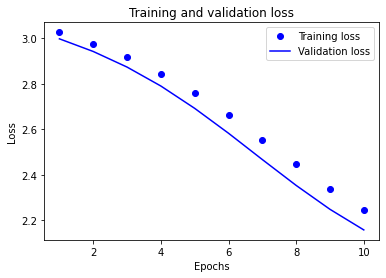

In [55]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

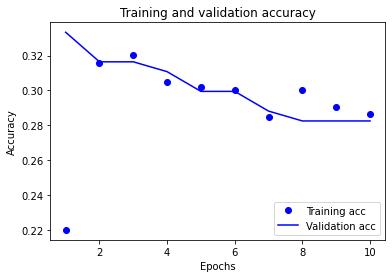

In [56]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [57]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

81/81 [==============================] - 4s 41ms/step - loss: 2.1732 - accuracy: 0.2910
0.28443580865859985


In [58]:
raw_train_ds.class_names

['african',
 'american',
 'asian',
 'bar',
 'burger',
 'cafe',
 'canadian',
 'caribbean',
 'central_american',
 'deli',
 'eastern_european',
 'european',
 'fast_food',
 'fish_and_seafood',
 'healthy',
 'middle_eastern',
 'pub',
 'seafood',
 'south_american',
 'vegan',
 'vegetarian']

In [72]:
examples = [
  "iceburg lettuce , Pea shoot, Mongo , Peeled potatoes, DOUBLE CREAM, MILK SEMI SKIMMED 2L, PARSNIPS 5KG, PEELED CARROT WHOLE,Classic burger 190 g,vegan slice cheese, sweet Potatoes fries , Apple sauce,  bisto gravy granules gluten free green box, Essential n1 veg gravy gluten free, English mustard, Moscovado sugar, tray, cheese, pastry,CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS,Tomatoe rulish,  bisto gravy granules gluten free green box, Piqillo red peper, fish, Self raising flour, tray,French beans, Heinz mayonnaise, AUBERGINE big size , POTATO SWEET, SPINACH BUNCH english, ROSEMARY, THYME, AVOCADO READY TO EAT,frozen lamb rump, Pork belly, CHICKEN FILLETS halal,sweet Potatoes fries , Oregano, Tomatoe rulish,  bisto gravy granules gluten free green box, Horseradish sauce, English mustard, chilli, picorino, CAMEMBERT ROUNDS, pastry,scoop, butternut, mushrooms, vegan slice cheese, Pea shoot, LEEK NET, MIX LEAF 2X500GR, DOUBLE CREAM,frozen lamb rump, cleaner, australian topside, CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,steak, Plant Burgers (4oz) Moving Mountain, frozen lamb rump,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,iceburg lettuce , Pea shoot, French beans, MIX LEAF 2X500GR, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, AUBERGINE big size , TOMATO 6KG, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L,bass, crayfish,iceburg lettuce , Peeled potatoes, CUCUMBER 30, POTATO SWEET,Roast poratoes, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4),french fries, Tomatoe rulish, Chinese breadcrumbs, Piqillo red peper, Barbecue sauce,lamb, Pea shoot, Nectarine , CUCUMBER 30, MIX LEAF 2X500GR, TOMATO 6KG, AVOCADO READY TO EAT, MILK SEMI SKIMMED 2L, DOUBLE CREAM,RIOPLATANESE ARG STRIPLOIN, proscutto, australian topside,Classic burger 190 g,Oregano, Chinese breadcrumbs, white cube sugar la peruche, brown cube sugar la peruche, White wine vinegar, Table salt, diced mango, Hollandaise sauce, CAMEMBERT ROUNDS, pastry, digestive biscuit,Calamari ,TENDER STEM BROCCOLI,HISPI CABBAGE 15S, LEEK NET, PARSNIPS 5KG, PEELED CARROT WHOLE,Calamari , Beetroot gravlax , Frozen hake ,French beans, Blue cheese, Heinz mayonnaise, TOMATO 6KG, FLAT LEAF PARSLEY, LEMONS BELSAN, BANANA CHIQUITA , EGG YOLK, HISPI CABBAGE 15S,bass, crayfish, Calamari ,proscutto, frozen lamb rump, WHOLE CHICKENS halal 1 kg each, australian topside, CHICKEN FILLETS halal,Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,ASPARAGUS ENGLISH 250G EXL,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes, Burger Halal Beef 30 x 170g (case),New potatoes, Nectarine , SLICED CHEDDAR CHEESE, Onion , COURGETTE, HISPI CABBAGE 15S, DILL, FLAT LEAF PARSLEY, TARRAGON, AVOCADO READY TO EAT, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, EGG YOLK,frozen lamb rump, ARGENTINIAN BEEF STRIPLOIN , CHICKEN FILLETS halal, WHOLE CHICKENS halal 1 kg each,pie, Calamari ,Risotto, risotto, picorino cheese, almond cream cheese, almonds, Barbecue sauce, moscovado, CAMEMBERT ROUNDS, pastry, Caster sugar , Sugar Demerara T&l - 4x3kg,DUCK LEGS (2LEGS PER PACK) precooked please, australian topside, CHICKEN FILLETS halal,scoop, onions, iceburg lettuce , TENDER STEM BROCCOLI, Log of goat cheese, AUBERGINE big size , CUCUMBER 30, PARSNIPS 5KG, PEELED CARROT WHOLE, DOUBLE CREAM, radichio, almond cream vegan cheese,Plant Burgers (4oz) Moving Mountain, frozen lamb rump,eggs, iceburg lettuce , Pea shoot, New potatoes, Mongo , mozzarella , CUCUMBER 30, FROZEN GARDEN PEAS 1KG, MIX LEAF 2X500GR, FLAT LEAF PARSLEY, BANANA CHIQUITA , DOUBLE CREAM, EGG YOLK, LEMONS BELSAN, DILL,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),iceburg lettuce , Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, POTATO SWEET, TOMATO 6KG, DOUBLE CREAM, MILK SEMI SKIMMED 2L,frozen lamb rump, ARGENTINIAN BEEF STRIPLOIN , Pork shoulder, Pork belly, CHICKEN FILLETS halal, australian topside,australian topside, CHICKEN FILLETS halal,brush, White wine vinegar, Hollandaise sauce, Baby cornichon , Large Tortilla, chilli, pastry,Heinz mayonnaise, SLICED CHEDDAR CHEESE, CAULIFLOWERS, FLAT MUSHROOM 1.8KG, AVOCADO READY TO EAT, DOUBLE CREAM,whole chicken 1 kg each, Eggs, Chicken breast bones off, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Chips: Lamb Weston Sweet Potato Fries - 10kg (case) - Frozen (LWF70), Roast poratoes,bass,bazel, mozzarella , SLICED CHEDDAR CHEESE, Peeled potatoes, CUCUMBER 30, HISPI CABBAGE 15S, MIX LEAF 2X500GR, TOMATO 6KG, AVOCADO READY TO EAT, NATURAL YOGURT 425G, iceburg lettuce ,Oregano, Tomatoe rulish, Raselhanout hanout, tray, pastry,black puddings , Mini sausage , Vegan burger, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), sliced vegan cheddar cheese,Breaded whitebeat , Side of fresh cod fillet, haddock,Pea shoot, Buternet squashed , Brie, Cavolonero , CAULIFLOWERS, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEELED CARROT WHOLE, TOMATO 6KG, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Classic burger 190 g,Classic burger 190 g,Eggs, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),Chopped tomato, Self raising flour, tray, cheese, Grated parmasan , CAMEMBERT ROUNDS, DIGESTIVE BISCUIT,iceburg lettuce , Buternet squashed , mozzarella , Pomegranate, BUTTER UNSALTED 40X250GR, Cavolonero , AUBERGINE big size , Onion , CAULIFLOWERS, FROZEN GARDEN PEAS 1KG, LEEK NET, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L,fresh or frozen halal lamb shanks, DUCK LEGS (2LEGS PER PACK) precooked please, CHICKEN FILLETS halal, Pork shoulder, AUSTRALIAN RIBEYE,French beans, New potatoes, PEPPERS RED, PEPPERS GREEN, PEPPERS YELLOW,mix beans, Essential n1 veg gravy gluten free, pork,crayfish, bass,brown cube sugar la peruche, white cube sugar la peruche,iceburg lettuce , rockets cress, Pea shoot, WHITE SEEDLESS GRAPES, DILL, ROSEMARY, TARRAGON, THYME, FLAT LEAF PARSLEY, BANANA SHALLOTS,mix beans, diced mango, puy lentils 1 x 1kg 10, Apple chutney, Barbecue sauce, Veal jus, Large Tortilla, american mustard, tumeric,Classic burger 190 g,striky bacon, CHICKEN FILLETS halal,Houmous, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger,iceburg lettuce , Heinz mayonnaise, Buternet squashed , SLICED CHEDDAR CHEESE, Peeled potatoes, AUBERGINE big size , PARSNIPS 5KG, PEELED CARROT WHOLE, PEELED GARLIC, POTATO SWEET, SPINACH BUNCH english, TOFU SMALL, AVOCADO READY TO EAT,iceburg lettuce , Mongo , BUTTER UNSALTED 40X250GR, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, SPINACH BUNCH english, MILK SEMI SKIMMED 2L,Peeled potatoes, Onion , LEEK NET, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEELED CARROT WHOLE, DILL, ROSEMARY, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L, SLICED CHEDDAR CHEESE,Cherry Vine Tomato,Plant Burgers (4oz) Moving Mountain, frozen lamb rump, australian topside,Classic burger 190 g,WHOLE CHICKENS halal 1 kg each,australian topside, WHOLE CHICKENS halal 1 kg each, PORK & LEEK SAUSAGES, SLICED HAM,iceburg lettuce , Harsh brown, Cavolonero , CUCUMBER 30, MIX LEAF 2X500GR,Pitted black olives, Baked beans, Tomatoe rulish, Barbecue sauce, brown cube sugar la peruche, white cube sugar la peruche, Penny pasta,  bisto gravy granules gluten free green box, Plain flour, Horseradish sauce, English mustard, Self raising flour, Caster sugar , Moscovado sugar, Large Tortilla, cheese, chilli, pastry, digestive biscuit,iceburg lettuce , Sour cream, Buternet squashed , Pomegranate, Peeled potatoes, CAULIFLOWERS, HISPI CABBAGE 15S, PEELED CARROT WHOLE, AVOCADO READY TO EAT, MILK SEMI SKIMMED 2L, Hallouml, Log of goat cheese, TOFU SMALL, TOMATO 6KG, DOUBLE CREAM, EGG YOLK,AUSTRALIAN RIBEYE, HIXSON FILLET HEADS WITH TAILS,Side of fresh cod fillet, Calamari ,Classic burger 190 g,Roast poratoes, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Eggs, whole chicken 1 kg each, Bacon, Chicken breast bones off,Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4),FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, MIX LEAF 2X500GR, MILK SEMI SKIMMED 2L,iceburg lettuce , Onion , BANANA SHALLOTS,bass, haddock, Lemon goujon ,Houmous, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger, Chips: Lamb Weston Sweet Potato Fries - 10kg (case) - Frozen (LWF70),mix beans, lid, diced mango, brush, Barbecue sauce, White quinoa,  bisto gravy granules gluten free green box, Essential n1 veg gravy gluten free, Piqillo red peper, Large Tortilla, CAMEMBERT ROUNDS,SLICED CHEDDAR CHEESE, Peeled potatoes, AUBERGINE big size , Onion , LEEK NET, MIX LEAF 2X500GR, PEELED GARLIC, POTATO SWEET, DOUBLE CREAM, MILK SEMI SKIMMED 2L, EGG YOLK,fresh or frozen halal lamb shanks, DUCK LEGS (2LEGS PER PACK) precooked please, CHICKEN FILLETS halal, SAUSAGE MEAT,Classic burger 190 g,FLAT MUSHROOM 1.8KG, PARSNIPS 5KG, PEELED CARROT WHOLE,iceburg lettuce , Pea shoot, Cavolonero , AUBERGINE big size , HISPI CABBAGE 15S, MIX LEAF 2X500GR, TOMATO 6KG, DOUBLE CREAM, MILK SEMI SKIMMED 2L, EGG YOLK,CUCUMBER 30,Baked beans, Tomatoe rulish, White quinoa, Penny pasta, English mustard, CAMEMBERT ROUNDS, pastry,WHOLE CHICKENS halal 1 kg each, australian topside, CHICKEN FILLETS halal, Pork shoulder, HIXSON FILLET HEADS WITH TAILS, ARGENTINIAN BEEF STRIPLOIN ,iceburg lettuce , Pea shoot, MIX LEAF 2X500GR, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Classic burger 190 g,sliced vegan cheddar cheese, Houmous, Eggs, Mini sausage , Bacon, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,Calamari , bass, Lemon goujon ,Harsh brown, mozzarella , Peeled potatoes, AUBERGINE big size , CAULIFLOWERS, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, AVOCADO READY TO EAT, NATURAL YOGURT 425G,DUCK LEGS (2LEGS PER PACK) precooked please, HIXSON FILLET HEADS WITH TAILS, striky bacon,crayfish, Smoked Salmon D-Cut Recon,New potatoes, AUBERGINE big size , HISPI CABBAGE 15S, MIX LEAF 2X500GR, SPINACH BUNCH english, MILK SEMI SKIMMED 2L,black puddings , Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Chicken breast bones off, Vegan burger,Chicken breast bones off, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Houmous,Pea shoot, Peeled potatoes, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, MILK SEMI SKIMMED 2L,WHITE SEEDLESS GRAPES, AVOCADO READY TO EAT, MILK SEMI SKIMMED 2L, iceburg lettuce , Heinz mayonnaise, Olive oil, mozzarella , LEEK NET, DOUBLE CREAM,AUSTRALIAN RIBEYE, CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,Chopped tomato,  bisto gravy granules gluten free green box, Plain flour, Hollandaise sauce, Cracked black pepper 500g, Self raising flour, pastry,RAINBOW CHARD, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, PEELED CARROT WHOLE, PARSNIPS 5KG, DOUBLE CREAM,Mongo , SLICED CHEDDAR CHEESE, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEELED CARROT WHOLE, DILL, FLAT LEAF PARSLEY, DOUBLE CREAM, MILK SEMI SKIMMED 2L,iceburg lettuce , New potatoes, SLICED CHEDDAR CHEESE, CUCUMBER 30, MILK SEMI SKIMMED 2L, EGG MEDIUM SMALL BOX, MIX LEAF 2X500GR,Classic burger 190 g,DUCK LEGS (2LEGS PER PACK) precooked please, australian topside,Mini sausage , Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,bass,iceburg lettuce , French beans, Cavolonero , AUBERGINE big size , CAULIFLOWERS, MIX LEAF 2X500GR, SPINACH BUNCH english, FLAT LEAF PARSLEY, DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G, Peeled potatoes, Onion ,iceburg lettuce , Heinz mayonnaise, Pea shoot, CAULIFLOWERS, CUCUMBER 30, HISPI CABBAGE 15S, MIX LEAF 2X500GR, TOMATO 6KG, DOUBLE CREAM, MILK SEMI SKIMMED 2L,crayfish, Frozen hake ,fresh or frozen halal lamb shanks, DUCK LEGS (2LEGS PER PACK) precooked please, CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS,tumeric, brush, Black peper cracked, Tomatoe rulish, Paprika, Penny pasta, Cumin powder,  bisto gravy granules gluten free green box, Baby cornichon , Baby onion, cheese, tray, CAMEMBERT ROUNDS, pastry,eggs, iceburg lettuce , SLICED CHEDDAR CHEESE, BUTTER UNSALTED 40X250GR, Peeled potatoes, AUBERGINE big size , Onion , FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, TOFU SMALL, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, AVOCADO READY TO EAT,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger, Chips: Lamb Weston Sweet Potato Fries - 10kg (case) - Frozen (LWF70),bass,iceburg lettuce , Pea shoot, PARSNIPS 5KG, PEELED CARROT WHOLE, RAINBOW CHARD, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Classic burger 190 g,CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS, PORK & LEEK SAUSAGES, SLICED HAM, Pork shoulder, Sliced bacon,French beans, New potatoes, Buternet squashed , Brie, mozzarella , Peeled potatoes, CAULIFLOWERS, FROZEN MIX FRUIT, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEELED CARROT WHOLE, DOUBLE CREAM, FLAT MUSHROOM 1.8KG, AVOCADO READY TO EAT, LEEK NET,DUCK LEGS (2LEGS PER PACK) precooked please, WHOLE CHICKENS halal 1 kg each, AUSTRALIAN RIBEYE, HIXSON FILLET HEADS WITH TAILS, CHICKEN FILLETS halal,Rolled Pork belly, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Houmous, black puddings ,CAULIFLOWERS, MIX LEAF 2X500GR, TOFU SMALL, AVOCADO READY TO EAT, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L,bass, Frozen hake ,sliced vegan cheddar cheese, Eggs, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Vegan burger, Roast poratoes,bass, crayfish, haddock, Smoked Salmon D-Cut Recon, Calamari ,Classic burger 190 g,ARGENTINIAN BEEF STRIPLOIN , australian topside, CHICKEN FILLETS halal, AUSTRALIAN RIBEYE, HIXSON FILLET HEADS WITH TAILS,iceburg lettuce , Heinz mayonnaise, Pea shoot, Buternet squashed , mozzarella , Peeled potatoes, AUBERGINE big size , CAULIFLOWERS, MIX LEAF 2X500GR, TOMATO 6KG, NATURAL YOGURT 425G, MILK SEMI SKIMMED 2L,mix beans, granola , capers, Oregano, Baked beans, Chinese breadcrumbs, Apple sauce, tray, Large Tortilla, chilli, pastry,Black peper cracked,  bisto gravy granules gluten free green box, Plain flour, Self raising flour,Chicken breast bones off, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Roast poratoes,SLICED CHEDDAR CHEESE, CAULIFLOWERS, CUCUMBER 30, HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, PEELED CARROT WHOLE, TOMATO 6KG, DOUBLE CREAM, MILK SEMI SKIMMED 2L,steak, proscutto, australian topside, CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS,brush, Baby cornichon , Baby onion, tray, Large Tortilla, tray, CAMEMBERT ROUNDS, pastry,HIXSON FILLET HEADS WITH TAILS, RIOPLATANESE ARG STRIPLOIN, AUSTRALIAN RIBEYE, SAUSAGE MEAT,mozzarella , Cavolonero , AUBERGINE big size , RAINBOW CHARD, AVOCADO READY TO EAT,Classic burger 190 g,Houmous, Eggs, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger, sliced vegan cheddar cheese, Chips: Lamb Weston Sweet Potato Fries - 10kg (case) - Frozen (LWF70),fresh or frozen halal lamb shanks, HIXSON FILLET HEADS WITH TAILS,brush, puy lentils 1 x 1kg 10, Baking powder , White quinoa, Penny pasta, Moscovado sugar, Large Tortilla, cheese,iceburg lettuce , French beans, New potatoes, FLAT MUSHROOM 1.8KG, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, PEELED GARLIC, POTATO SWEET, DILL, TARRAGON, DOUBLE CREAM, MILK SEMI SKIMMED 2L,mix beans, brush, Oregano, Baked beans, Barbecue sauce, Essential n1 veg gravy gluten free, Horseradish sauce, English mustard, Dijon mustard , cheese, Grated parmasan , pastry,cleaner, striky bacon, CHICKEN FILLETS halal, Pork shoulder,Hallouml, Buternet squashed , SLICED CHEDDAR CHEESE, FROZEN GARDEN PEAS 1KG, MIX LEAF 2X500GR, SPINACH BUNCH english, MILK SEMI SKIMMED 2L, Olive oil, DOUBLE CREAM, CUCUMBER 30, EGG YOLK,Classic burger 190 g,iceburg lettuce , Hallouml, Buternet squashed , Peeled potatoes, Log of goat cheese, HISPI CABBAGE 15S, MIX LEAF 2X500GR, MILK SEMI SKIMMED 2L, LEMONS BELSAN, CUCUMBER 30, TOMATO 6KG, AVOCADO READY TO EAT,sliced vegan cheddar cheese, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),WHOLE CHICKENS halal 1 kg each, australian topside, PORK & LEEK SAUSAGES, CHICKEN FILLETS halal, Pork belly, Sliced bacon, DUCK LEGS (2LEGS PER PACK) precooked please,bass,Pea shoot, LEEK NET, MIX LEAF 2X500GR, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,mix beans, puy lentils 1 x 1kg 10, Penny pasta, Plain flour, Self raising flour, cheese, Dates, tray, digestive biscuit, Chinese breadcrumbs,fresh or frozen halal lamb shanks, CHICKEN FILLETS halal,iceburg lettuce , French beans, New potatoes, Heinz mayonnaise, Peeled potatoes, Onion , HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEPPERS RED, PEPPERS GREEN, PEPPERS YELLOW, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, AVOCADO READY TO EAT, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,bass, crayfish, Smoked Salmon D-Cut Recon,Heinz mayonnaise, BUTTER UNSALTED 40X250GR, Peeled potatoes, CAULIFLOWERS, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEPPERS RED, PEPPERS YELLOW, POTATO SWEET, PEPPERS GREEN, FLAT LEAF PARSLEY, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Classic burger 190 g,Classic burger 190 g,Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,iceburg lettuce , Heinz mayonnaise, New potatoes, CAULIFLOWERS, FROZEN GARDEN PEAS 1KG, MIX LEAF 2X500GR, PEELED GARLIC, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, RED SEEDLESS GRAPES, AVOCADO READY TO EAT, DOUBLE CREAM,MILK SEMI SKIMMED 2L, LEEK NET, TOMATO 6KG, French beans,puy lentils 1 x 1kg 10, CAMEMBERT ROUNDS, pastry, diced mango, Hollandaise sauce,bass, crayfish,WHOLE CHICKENS halal 1 kg each,bass, Frozen hake ,bass, crayfish, Calamari ,bag, pudding, flour, onions,brown cube sugar la peruche, fish, brush, pepper,Pea shoot, New potatoes, Baby rinbow carrot, Heritage Beetroot, COURGETTE, HISPI CABBAGE 15S, SPINACH BUNCH english, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,DUCK LEGS (2LEGS PER PACK) precooked please,HIXSON FILLET HEADS WITH TAILS, steak,humus, iceburg lettuce , French beans, New potatoes, CUCUMBER 30, AVOCADO READY TO EAT, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L,frozen lamb rump, CHICKEN FILLETS halal, VEAL BONES,Apple sauce, Baby onion, tray, Grated parmasan , CAMEMBERT ROUNDS,Veal jus, CAMEMBERT ROUNDS, pastry, Red onion Marmalade, Plain flour,  bisto gravy granules gluten free green box, Essential n1 veg gravy gluten free, Chinese breadcrumbs, Self raising flour,iceburg lettuce , French beans, New potatoes, Heinz mayonnaise, AUBERGINE big size , MIX LEAF 2X500GR, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, DOUBLE CREAM,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,Chicken breast bones off, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,Plant Burgers (4oz) Moving Mountain, frozen lamb rump, Pork shoulder,australian topside, CHICKEN FILLETS halal,COURGETTE,AUBERGINE big size , CUCUMBER 30, NATURAL YOGURT 425G,Plain flour, Self raising flour, cheese, CAMEMBERT ROUNDS, pastry,eggs, iceburg lettuce , French beans, Pea shoot, New potatoes, Buternet squashed , Brie, mozzarella , SLICED CHEDDAR CHEESE, BUTTER UNSALTED 40X250GR, Peeled potatoes, AUBERGINE big size , Onion , BANANA SHALLOTS, CAULIFLOWERS, CORIANDER , CUCUMBER 30, HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, POTATO SWEET, RED SEEDLESS GRAPES, TOFU SMALL, TOMATO 6KG, ROSEMARY, TARRAGON, THYME, LEMONS BELSAN, EGG YOLK,Houmous, Chicken breast bones off, Roast poratoes, Vegan burger,humus, beans,horseradish, eggs, French beans, New potatoes, Mongo , Heinz mayonnaise, Baby rinbow carrot, Heritage Beetroot, SLICED CHEDDAR CHEESE, Peeled potatoes, Log of goat cheese, AUBERGINE big size , Onion , CUCUMBER 30, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, LEEK NET, PEELED GARLIC, PEELED CARROT WHOLE, POTATO SWEET, SPINACH BUNCH english, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, ROSEMARY, TARRAGON, LEMONS BELSAN, BANANA CHIQUITA , DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L, TENDER STEM BROCCOLI,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,humus, iceburg lettuce , Pea shoot, French beans, Peeled potatoes, CAULIFLOWERS, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, PEELED CARROT WHOLE, PEELED GARLIC, TARRAGON, LEMONS BELSAN, BANANA CHIQUITA , EGG YOLK, DOUBLE CREAM, NATURAL YOGURT 425G,steak, HIXSON FILLET HEADS WITH TAILS, RIOPLATANESE ARG STRIPLOIN,Classic burger 190 g,DILL, FLAT LEAF PARSLEY, MINT,Mongo , SLICED CHEDDAR CHEESE, Peeled potatoes, Cavolonero , AUBERGINE big size , HISPI CABBAGE 15S, SPINACH BUNCH english, AVOCADO READY TO EAT, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,Houmous, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),Plant Burgers (4oz) Moving Mountain, CHICKEN FILLETS halal,Classic burger 190 g,iceburg lettuce , Hallouml, Pea shoot, French beans, Heinz mayonnaise, SLICED CHEDDAR CHEESE, Peeled potatoes, CUCUMBER 30, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, POTATO SWEET, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L, FROZEN GARDEN PEAS 1KG,frozen lamb rump, australian topside, Sliced bacon, CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,Pea shoot, New potatoes, Peeled potatoes, Cavolonero , Log of goat cheese, CAULIFLOWERS, CORIANDER , FROZEN GARDEN PEAS 1KG, MIX LEAF 2X500GR, TOMATO 6KG, FLAT LEAF PARSLEY, DILL,SLICED CHEDDAR CHEESE, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, PEELED GARLIC, TOMATO 6KG, NATURAL YOGURT 425G,beef, halal, bisto gravy granules gluten free green box, Piqillo red peper, Black peper cracked, Hollandaise sauce, English mustard, cheese, CAMEMBERT ROUNDS, pastry, Sweet potatoes chips, sweet Potatoes fries , drinking chocolate,humus, Apple sauce, Moscovado sugar, CAMEMBERT ROUNDS, pastry,iceburg lettuce , Pea shoot, Mongo , Peeled potatoes, Log of goat cheese, AUBERGINE big size , CUCUMBER 30, FROZEN GARDEN PEAS 1KG, LEEK NET, SPINACH BUNCH english, LEMONS BELSAN, DOUBLE CREAM, MIX LEAF 2X500GR,BANANA CHIQUITA ,Pork belly, CHICKEN FILLETS halal,Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),Calamari , Frozen hake ,drinking chocolate, french fries, beans, Cajun, Plain flour, Self raising flour,frozen lamb rump, proscutto, steak,Pea shoot, Mongo , Nectarine , Peeled potatoes, COURGETTE, CUCUMBER 30, SPINACH BUNCH english, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G, DOUBLE CREAM,Biscuit for cheese,sliced vegan cheddar cheese, Houmous, Chicken breast bones off, Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger, Roast poratoes, Chips: Lamb Weston Sweet Potato Fries - 10kg (case) - Frozen (LWF70),Classic burger 190 g,Frozen hake , Calamari , Beetroot gravlax , salmon,Classic burger 190 g,MILK SEMI SKIMMED 2L, humus,CHICKEN FILLETS halal,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes, Vegan burger,CHICKEN FILLETS halal, Pork shoulder,humus, eggs, CUCUMBER 30, MIX LEAF 2X500GR, SPINACH BUNCH english, AVOCADO READY TO EAT, BANANA CHIQUITA , DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,Classic burger 190 g,iceburg lettuce , Olive oil, PARSNIPS 5KG, PEELED CARROT WHOLE, DILL,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,LEEK NET,moscovado, risotto, drinking chocolate, lid, green pistou, Raselhanout hanout, brown cube sugar la peruche, Apple sauce,  bisto gravy granules gluten free green box, brush, crumberries sauce, Plain flour, Horseradish sauce, Hollandaise sauce, English mustard, Cracked black pepper 500g, Self raising flour, Baby cornichon , Red onion Marmalade, Moscovado sugar, Baby onion, tray, cheese, Dates, CAMEMBERT ROUNDS, pastry, french fries, Chinese breadcrumbs, Salt Sachets , caramelized onion, Tomatoe rulish, Essential n1 veg gravy gluten free, Veal jus, digestive biscuit,Baby rinbow carrot, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Tomatoe rulish, Penny pasta, Plain flour, chilli, pastry,WHOLE CHICKENS halal 1 kg each,French beans, Peeled potatoes, AUBERGINE big size , HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEPPERS YELLOW, PEPPERS RED, PEPPERS GREEN, LEMONS BELSAN, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L,mozzarella , HISPI CABBAGE 15S, MIX LEAF 2X500GR, TOMATO 6KG, FLAT LEAF PARSLEY, DILL, AVOCADO READY TO EAT, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,ARGENTINIAN BEEF STRIPLOIN , frozen lamb rump, HIXSON FILLET HEADS WITH TAILS,Classic burger 190 g,Frozen hake , Calamari ,eggs, mozzarella , SLICED CHEDDAR CHEESE, HISPI CABBAGE 15S, MIX LEAF 2X500GR, AVOCADO READY TO EAT, BANANA CHIQUITA , MILK SEMI SKIMMED 2L, DOUBLE CREAM,Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),frozen lamb rump,Peeled potatoes, MIX LEAF 2X500GR, AVOCADO READY TO EAT, BANANA CHIQUITA ,Piqillo red peper, Self raising flour, Moscovado sugar, CAMEMBERT ROUNDS, candansat milk,Beternut squach well, Red onion, WHITE SEEDLESS GRAPES,Classic burger 190 g,Hollandaise sauce, vegan slice cheese, Penny pasta, chilli,bass, Lemon goujon ,Dates, drinking chocolate,Nectarine ,iceburg lettuce , Veg oil, NATURAL YOGURT 425G, MILK SEMI SKIMMED 2L,Cherry Vine Tomato, radichio, Pea shoot, Blue cheese, Heinz mayonnaise, BUTTER UNSALTED 40X250GR, PEELED CARROT WHOLE, PARSNIPS 5KG, TOMATO 6KG, FLAT LEAF PARSLEY, THYME, EGG YOLK,Heinz mayonnaise, Peeled potatoes, MIX LEAF 2X500GR, POTATO SWEET, FLAT LEAF PARSLEY, DILL, Log of goat cheese,CHICKEN FILLETS halal,Classic burger 190 g,iceburg lettuce , Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, ROSEMARY, DOUBLE CREAM, MILK SEMI SKIMMED 2L,french fries,Heinz mayonnaise, SLICED CHEDDAR CHEESE, Peeled potatoes, AUBERGINE big size , LEEK NET, PARSNIPS 5KG, PEELED CARROT WHOLE, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L,Classic burger 190 g,Sweet potatoes chips, chilli, french fries,pork,Classic burger 190 g, sausage,bass, Frozen hake , crayfish,groud white peper, Baking powder , Chopped tomato, Chinese breadcrumbs, Cracked black pepper 500g, Caster sugar , tray, Tomatoes purre , Grated parmasan , CAMEMBERT ROUNDS,Classic burger 190 g,mushrooms, iceburg lettuce , MIX LEAF 2X500GR, TOMATO 6KG,iceburg lettuce , mozzarella , Onion , CUCUMBER 30, MIX LEAF 2X500GR, POTATO SWEET, TOMATO 6KG, LEMONS BELSAN,Pork belly, WHOLE CHICKENS halal 1 kg each, CHICKEN FILLETS halal,sausage,Plant Burgers (4oz) Moving Mountain, CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS, cleaner, RIOPLATANESE ARG STRIPLOIN,salmon,iceburg lettuce , New potatoes, Mongo , LEEK NET, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, LEMONS BELSAN,iceburg lettuce , Pea shoot, French beans, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, SPINACH BUNCH english, AVOCADO READY TO EAT, MILK SEMI SKIMMED 2L, BANANA CHIQUITA ,bass, crayfish,drinking chocolate, Dates, chilli, CAMEMBERT ROUNDS, pastry,Pork belly, australian topside, RIOPLATANESE ARG STRIPLOIN,Classic burger 190 g,french fries, iceburg lettuce , Pea shoot, COURGETTE, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, ROSEMARY, THYME, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L, EGG YOLK,french fries, iceburg lettuce , DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,Chips: Lamb Weston skin off stealth  9/9 fries- x 2.5Kg (case) - Frozen (SO4), Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes, Chips: Lamb Weston Sweet Potato Fries - 10kg (case) - Frozen (LWF70),Classic burger 190 g,Sachet English mustard, Sachet mayonnaise , Hollandaise sauce, Moscovado sugar, beans,FENNEL, Heinz mayonnaise, Peeled potatoes, Onion , LEEK NET, MIX LEAF 2X500GR, PEELED CARROT WHOLE, TOMATO 6KG, ROSEMARY, LEMONS BELSAN, ROCKET 2X500GR, DOUBLE CREAM, frozen cremberies, Sour cream, glass, sage, MILK SEMI SKIMMED 2L,steak, Pork belly, australian topside, CHICKEN FILLETS halal,steak chips,eggs, Veg oil, SLICED CHEDDAR CHEESE, Peeled potatoes, COURGETTE, MIX LEAF 2X500GR,Brussels sprout,bass,MIX LEAF 2X500GR, Lamb&Weston Chips Stealth 9x18Mm Skin On (4x2.5Kg),LEEK NET, HISPI CABBAGE 15S,Peeled potatoes, PARSNIPS 5KG, PEELED CARROT WHOLE,iceburg lettuce ,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,sweet Potatoes fries ,New potatoes, French beans, MIX LEAF 2X500GR, LEMONS BELSAN, MILK SEMI SKIMMED 2L,flour, lamb, avocados, brownie,Roast poratoes, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, POTATO SWEET, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L, Onion ,steak, frozen lamb rump,iceburg lettuce , Pea shoot, New potatoes, Nectarine , SLICED CHEDDAR CHEESE, AUBERGINE big size , CUCUMBER 30, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, DILL, ROSEMARY, TARRAGON, LEMONS BELSAN, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L, COURGETTE, Peeled potatoes, TOMATO 6KG, horseradish,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),sweet Potatoes fries ,french fries, chocolat sauce, tumeric, Paprika, Cumin powder, Table salt, Essential n1 veg gravy gluten free,  bisto gravy granules gluten free green box, fish, capers, Hollandaise sauce, Cracked black pepper 500g, Caster sugar , CAMEMBERT ROUNDS, digestive biscuit,Baby onion, groud white peper, Baking powder , Mint sauce, Barbecue sauce, Biscuit for cheese, Essential n1 veg gravy gluten free,  bisto gravy granules gluten free green box, crumberries sauce, Cracked black pepper 500g, Peper corne sauce , Dates, pastry,iceburg lettuce , Pea shoot, AUBERGINE big size , CORIANDER , LEEK NET, MIX LEAF 2X500GR, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Veg oil, Peeled potatoes, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, MILK SEMI SKIMMED 2L,steak, proscutto, frozen lamb rump, CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,humus, french fries, iceburg lettuce , Pea shoot, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, ROSEMARY, THYME, LEMONS BELSAN, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,beef, Roast poratoes, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),TOMATO 6KG, AVOCADO READY TO EAT, MILK SEMI SKIMMED 2L, SLICED CHEDDAR CHEESE, CUCUMBER 30, PEPPERS GREEN, PEPPERS RED, AUBERGINE big size , EGG YOLK,cheese,Classic burger 190 g,Pork belly, DUCK LEGS (2LEGS PER PACK) precooked please, australian topside, CHICKEN FILLETS halal,Mongo , Heinz mayonnaise, Baby rinbow carrot, HISPI CABBAGE 15S, MIX LEAF 2X500GR, SPINACH BUNCH english, LEMONS BELSAN, DOUBLE CREAM, NATURAL YOGURT 425G,mushrooms, frozen cremberies, CAULIFLOWERS, HISPI CABBAGE 15S, PARSNIPS 5KG, PEELED CARROT WHOLE, TOMATO 6KG, DOUBLE CREAM, MILK SEMI SKIMMED 2L, EGG YOLK,proscutto, frozen lamb rump,Plant Burgers (4oz) Moving Mountain,FROZEN GARDEN PEAS 1KG, SPINACH BUNCH english, DILL, FLAT LEAF PARSLEY, AVOCADO READY TO EAT, MILK SEMI SKIMMED 2L, Onion ,New potatoes, SPINACH BUNCH english, french fries, Mongo ,steak, Pork shoulder,Sachet English mustard, Sachet mayonnaise ,  bisto gravy granules gluten free green box, Penny pasta, brown cube sugar la peruche, Self raising flour, CAMEMBERT ROUNDS, sachet peper, Salt Sachets , vinigar malt sachet,Classic burger 190 g,sausage, CHICKEN FILLETS halal,iceburg lettuce , MIX LEAF 2X500GR, Hallouml, AVOCADO READY TO EAT,pie, Calamari ,steak, CHICKEN FILLETS halal, Sliced bacon,french fries, eggs, iceburg lettuce , Hallouml, Pea shoot, French beans, Peeled potatoes, COURGETTE, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, MIX LEAF 2X500GR, DOUBLE CREAM, LEMONS BELSAN, SLICED CHEDDAR CHEESE, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,bass, crayfish,Calamari ,bass, crayfish, Breaded whitebeat ,bass,bass, crayfish,pie, bass,Calamari , Frozen hake ,bass, crayfish,SLICED CHEDDAR CHEESE, AUBERGINE big size , COURGETTE, LEEK NET, ROSEMARY, LEMONS BELSAN,Cherry Vine Tomato, Camembert  250 g, French beans, AUBERGINE big size , CUCUMBER 30, FROZEN GARDEN PEAS 1KG, LEEK NET, POTATO SWEET, DILL, FLAT LEAF PARSLEY, MILK SEMI SKIMMED 2L,french fries, sweet Potatoes fries , Table salt, Cracked black pepper 500g, chilli,ARGENTINIAN BEEF STRIPLOIN , CHICKEN FILLETS halal, AUSTRALIAN RIBEYE,Classic burger 190 g,bass,iceburg lettuce , New potatoes, Peeled potatoes, MIX LEAF 2X500GR, HISPI CABBAGE 15S, SPINACH BUNCH english, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, TOMATO 6KG,French beans, LEMONS BELSAN, MIX LEAF 2X500GR, eggs, iceburg lettuce , Heinz mayonnaise, Peeled potatoes, HISPI CABBAGE 15S, TOMATO 6KG, ROSEMARY, MILK SEMI SKIMMED 2L, DOUBLE CREAM,Tomatoe rulish, Cajun, Plain flour, English mustard, tray, cheese, chilli, CAMEMBERT ROUNDS, pastry,Classic burger 190 g,Classic burger 190 g,iceburg lettuce , SLICED CHEDDAR CHEESE, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, DOUBLE CREAM, MILK SEMI SKIMMED 2L,humus, french fries, iceburg lettuce , Pea shoot, French beans, Heinz mayonnaise, Nectarine , Onion , COURGETTE, CUCUMBER 30, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, DILL, FLAT LEAF PARSLEY, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L, AUBERGINE big size , HISPI CABBAGE 15S,Plant Burgers (4oz) Moving Mountain,Classic burger 190 g,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes, Vegan burger,bass, crayfish,ARGENTINIAN BEEF STRIPLOIN , AUSTRALIAN RIBEYE, HIXSON FILLET HEADS WITH TAILS,beef, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger,Peeled potatoes, AUBERGINE big size , Mongo , Pea shoot, LEEK NET, MIX LEAF 2X500GR, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, TARRAGON, LEMONS BELSAN, iceburg lettuce ,Classic burger 190 g,frozen lamb rump,AUSTRALIAN RIBEYE, CHICKEN FILLETS halal,cabernet sauvignon, french fries, Whole grey mustard, Essential n1 veg gravy gluten free, Dates, pastry,bass, crayfish, pie,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,french fries, sweet Potatoes fries , Tomatoe rulish, Penny pasta, Apple sauce, Essential n1 veg gravy gluten free,  bisto gravy granules gluten free green box, diced mango, cheese, pastry, digestive biscuit, Moscovado sugar, CAMEMBERT ROUNDS, Baking powder , Black peper corn,humus, iceburg lettuce , Pea shoot, French beans, New potatoes, Heinz mayonnaise, Nectarine , BUTTER UNSALTED 40X250GR, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, ROSEMARY, THYME, COURGETTE, CUCUMBER 30, mozzarella ,brush, Plain flour, Self raising flour,Classic burger 190 g,Classic burger 190 g,Peeled potatoes, Pea shoot, HISPI CABBAGE 15S, MIX LEAF 2X500GR, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, iceburg lettuce , New potatoes,MIX LEAF 2X500GR,HISPI CABBAGE 15S, MIX LEAF 2X500GR, POTATO SWEET, LEMONS BELSAN,proscutto, Plant Burgers (4oz) Moving Mountain, frozen lamb rump, australian topside, CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS,Pork shoulder,Penny pasta, Essential n1 veg gravy gluten free, Red onion Marmalade, CAMEMBERT ROUNDS, pastry,CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,Plain flour, Self raising flour, pastry,Frozen hake , Calamari ,Classic burger 190 g,Calamari ,steak, frozen lamb rump, CHICKEN FILLETS halal, Pork shoulder,Mongo , Peeled potatoes, Log of goat cheese, Onion , CORIANDER , MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, SPINACH BUNCH english, FLAT LEAF PARSLEY, DILL, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L,eggs, iceburg lettuce , Pea shoot, CUCUMBER 30, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L, TOMATO 6KG,Essential n1 veg gravy gluten free,  bisto gravy granules gluten free green box, fish, Hollandaise sauce, Moscovado sugar, chilli, pastry,Pork belly, WHOLE CHICKENS halal 1 kg each, CHICKEN FILLETS halal,Pea shoot, AUBERGINE big size , COURGETTE, CUCUMBER 30, FROZEN GARDEN PEAS 1KG, MIX LEAF 2X500GR, LEMONS BELSAN, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L,french fries, Chinese breadcrumbs,bass, crayfish, Calamari ,DUCK LEGS (2LEGS PER PACK) precooked please, CHICKEN FILLETS halal, Sliced bacon,Plant Burgers (4oz) Moving Mountain, australian topside, CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN, Pigs in blunket,iceburg lettuce , Pea shoot, French beans, Heinz mayonnaise, Beternut squach well, Peeled potatoes, TENDER STEM BROCCOLI, Log of goat cheese, Onion , FROZEN GARDEN PEAS 1KG, MIX LEAF 2X500GR, POTATO SWEET, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, MILK SEMI SKIMMED 2L, DOUBLE CREAM,eggs, Pea shoot, French beans, TENDER STEM BROCCOLI, Onion , CORIANDER , MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, DILL, FLAT LEAF PARSLEY, ROSEMARY, LEMONS BELSAN, DOUBLE CREAM, EGG YOLK, iceburg lettuce ,Pea shoot, New potatoes, HISPI CABBAGE 15S, FLAT LEAF PARSLEY, DILL,LEEK NET,frozen lamb rump, australian topside, RIOPLATANESE ARG STRIPLOIN,vegan slice cheese, french fries, beans, Tomatoe rulish, Tomatoes purre ,bass,Classic burger 190 g,pie, Lemon goujon ,Cherry Vine Tomato, Pea shoot, New potatoes, Baby rinbow carrot, Heritage Beetroot, MIX LEAF 2X500GR, TOMATO 6KG, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L,BANANA CHIQUITA ,French beans, SLICED CHEDDAR CHEESE, LEEK NET, PEELED CARROT WHOLE, MILK SEMI SKIMMED 2L,sliced vegan cheddar cheese, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,CHICKEN FILLETS halal, Pork shoulder,bowl, peanuts, Horseradish sauce, brush, pastry, Self raising flour, Plain flour, almonds, pork, Tomatoe rulish, English mustard,Pork shoulder,whole chicken 1 kg each, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,french fries, sweet Potatoes fries , CAMEMBERT ROUNDS,frozen lamb rump, australian topside, CHICKEN FILLETS halal, Sliced bacon,French beans, New potatoes, Mongo , Onion , COURGETTE, MIX LEAF 2X500GR, AVOCADO READY TO EAT, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, EGG YOLK,Peeled potatoes,Peeled potatoes, SPINACH BUNCH english, THYME, LEMONS BELSAN, MILK SEMI SKIMMED 2L,Tomatoe rulish, Cajun, Apple sauce, pastry, Caramel condensat,Plant Burgers (4oz) Moving Mountain, Pork belly, WHOLE CHICKENS halal 1 kg each, CHICKEN FILLETS halal, australian topside,iceburg lettuce , AUBERGINE big size , CUCUMBER 30, PARSNIPS 5KG, PEELED CARROT WHOLE, DOUBLE CREAM, MILK SEMI SKIMMED 2L,crayfish, Frozen hake , bass, Calamari ,bass, Frozen hake ,bass, crayfish,Frozen hake , Calamari ,bass, crayfish, Calamari ,iceburg lettuce , Pea shoot, Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, DOUBLE CREAM, MILK SEMI SKIMMED 2L, FROZEN GARDEN PEAS 1KG,CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,Classic burger 190 g,bass,Peeled potatoes, HISPI CABBAGE 15S, MIX LEAF 2X500GR, TOMATO 6KG, LEMONS BELSAN,steak, frozen lamb rump, HIXSON FILLET HEADS WITH TAILS, CHICKEN FILLETS halal,CHICKEN FILLETS halal, DUCK LEGS (2LEGS PER PACK) precooked please,CHICKEN FILLETS halal, steak,mushrooms, iceburg lettuce , Hallouml, New potatoes, Mongo , Baby rinbow carrot, Peeled potatoes, TENDER STEM BROCCOLI, Onion , HISPI CABBAGE 15S, MIX LEAF 2X500GR, DILL, FLAT LEAF PARSLEY, LEMONS BELSAN, MILK SEMI SKIMMED 2L, DOUBLE CREAM, SLICED CHEDDAR CHEESE, BANANA CHIQUITA ,horseradish, french fries, iceburg lettuce , Pea shoot, New potatoes, French beans, Mongo , Peeled potatoes, CUCUMBER 30, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, POTATO SWEET, SPINACH BUNCH english, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L,Classic burger 190 g,bass,chocolat sauce, french fries, sweet Potatoes fries , Chinese breadcrumbs,  bisto gravy granules gluten free green box, Self raising flour, CAMEMBERT ROUNDS, pastry,iceburg lettuce , humus, AUBERGINE big size , CUCUMBER 30, MIX LEAF 2X500GR, TOMATO 6KG,iceburg lettuce , SLICED CHEDDAR CHEESE, MIX LEAF 2X500GR, AVOCADO READY TO EAT, BANANA CHIQUITA , EGG YOLK, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,steak, CHICKEN FILLETS halal,mozzarella ,Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Vegan burger,french fries, Tomatoe rulish, brush, tray, cheese, Dates,Classic burger 190 g,humus, iceburg lettuce , Peeled potatoes, CUCUMBER 30, FROZEN GARDEN PEAS 1KG, COURGETTE, HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, PEELED CARROT WHOLE, FLAT LEAF PARSLEY, LEMONS BELSAN, DOUBLE CREAM,CHICKEN FILLETS halal, Pork shoulder,frozen lamb rump,australian topside,Cherry Vine Tomato, french fries, iceburg lettuce , Pea shoot, Baby rinbow carrot, TENDER STEM BROCCOLI, HISPI CABBAGE 15S, MIX LEAF 2X500GR, TOMATO 6KG, LEMONS BELSAN, DOUBLE CREAM, MILK SEMI SKIMMED 2L,DUCK LEGS (2LEGS PER PACK) precooked please, CHICKEN FILLETS halal, RIOPLATANESE ARG STRIPLOIN,bass, crayfish, Calamari ,bass, Frozen hake , Calamari ,MIX LEAF 2X500GR, TOMATO 6KG, DOUBLE CREAM,Roast poratoes, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84),steak chips, vegan slice cheese, beans, pastry, CAMEMBERT ROUNDS, chocolat sauce,bass, crayfish, Frozen hake ,Plant Burgers (4oz) Moving Mountain, australian topside, CHICKEN FILLETS halal, HIXSON FILLET HEADS WITH TAILS, RIOPLATANESE ARG STRIPLOIN, DUCK LEGS (2LEGS PER PACK) precooked please,frozen lamb rump,Lamb&Weston Chips Stealth 9x18Mm Skin On (4x2.5Kg), french fries, eggs, iceburg lettuce , Pea shoot, mozzarella , Nectarine , AUBERGINE big size , Red onion, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, MIX LEAF 2X500GR, Heinz mayonnaise, COURGETTE, PARSNIPS 5KG, PEELED CARROT WHOLE, SPINACH BUNCH english, LEMONS BELSAN, AVOCADO READY TO EAT, DOUBLE CREAM, MILK SEMI SKIMMED 2L,BANANA CHIQUITA ,Classic burger 190 g,Heritage Beetroot, iceburg lettuce , Peeled potatoes, Onion , HISPI CABBAGE 15S, LEEK NET,australian topside, HIXSON FILLET HEADS WITH TAILS, CHICKEN FILLETS halal,Classic burger 190 g,Baby rinbow carrot, vegan slice cheese, DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G, ROSEMARY, THYME, TOMATO 6KG, SPINACH BUNCH english, MIX LEAF 2X500GR, HISPI CABBAGE 15S, iceburg lettuce , Pea shoot, New potatoes, Mongo , Log of goat cheese, AUBERGINE big size , CUCUMBER 30, LEMONS BELSAN, BANANA CHIQUITA , EGG YOLK,Chinese breadcrumbs, Plain flour, English mustard, Self raising flour, Moscovado sugar, puy lentils 1 x 1kg 10, chilli, pastry,flour,peanuts,parchment,steak, Plant Burgers (4oz) Moving Mountain, CHICKEN FILLETS halal,French beans, Heinz mayonnaise, Peeled potatoes, AUBERGINE big size , HISPI CABBAGE 15S, LEEK NET, MIX LEAF 2X500GR, TOMATO 6KG, DILL, FLAT LEAF PARSLEY, BANANA CHIQUITA , MILK SEMI SKIMMED 2L, New potatoes,australian topside, CHICKEN FILLETS halal,bass, Frozen hake , Calamari ,bazel, Heinz mayonnaise, AUBERGINE big size , PEPPERS GREEN, PEPPERS RED, PEPPERS YELLOW, FLAT LEAF PARSLEY, DILL, DOUBLE CREAM, EGG YOLK, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,humus, mozzarella , PEELED CARROT WHOLE,bag, potatoes, pudding, flour,Plant Burgers (4oz) Moving Mountain, frozen lamb rump, Pork belly, Sliced bacon,Pork shoulder,french fries, sweet Potatoes fries , cheese, pastry, Chopped tomato, Whole grey mustard,iceburg lettuce , COURGETTE, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, MILK SEMI SKIMMED 2L,Classic burger 190 g,steak, proscutto, frozen lamb rump, WHOLE CHICKENS halal 1 kg each, australian topside, CHICKEN FILLETS halal,eggs, stilton , HISPI CABBAGE 15S, LEEK NET, DILL, FLAT LEAF PARSLEY,french fries, Salt Sachets , Oregano, White wine vinegar, Biscuit for cheese, crumberries sauce, pastry,New potatoes, Peeled potatoes, MIX LEAF 2X500GR, DOUBLE CREAM, MILK SEMI SKIMMED 2L,bass, Frozen hake ,Classic burger 190 g,whole chicken 1 kg each, Chips: Lamb Weston Steakhouse 9/18 - x 2.5Kg (case) - Frozen (LWF84), Roast poratoes,french fries, Pea shoot, Mongo , mozzarella , SLICED CHEDDAR CHEESE, AUBERGINE big size , COURGETTE, HISPI CABBAGE 15S, MIX LEAF 2X500GR, BANANA CHIQUITA , DOUBLE CREAM, MILK SEMI SKIMMED 2L, NATURAL YOGURT 425G,australian topside, Pork belly,sausage, Classic burger 190 g, chicken,iceburg lettuce , Pea shoot, French beans, SLICED CHEDDAR CHEESE, Brussels sprout, ROCKET 2X500GR, Peeled potatoes, FROZEN GARDEN PEAS 1KG, HISPI CABBAGE 15S, MIX LEAF 2X500GR, PARSNIPS 5KG, PEELED CARROT WHOLE, FLAT LEAF PARSLEY, LEMONS BELSAN, MILK SEMI SKIMMED 2L, feta,sage, iceburg lettuce , Pea shoot, SLICED CHEDDAR CHEESE, LEMONS BELSAN, frozen cremberies, LEEK NET,CHICKEN FILLETS halal,vegan brownie, french fries, hake, tray, 1 box squid tubes - u5, blade orange ice cream, nutella,Mango sorbet, hake, bag, Strawberries ice cream , Chocolate ice cream,nutella, hake, focaccia, 1 box squid tubes - u5, Mango sorbet,hake, gorgonzola, focaccia,hake, gorgonzola, mozzarella, 1 box squid tubes - u5, focaccia,2 vegan vanilla ice cream, chopped tomatoes , hake, 1 box squid tubes - u5, focaccia,nutella, hake, 1 box squid tubes - u5,hake, french fries, 1 box squid tubes - u5,chopped tomatoes , hake, 1 box squid tubes - u5, focaccia,chopped tomatoes , nutella, hake, 1 box squid tubes - u5,french fries, bag,nutella,salted caramel, Vegan vanilla ice cream,Vegan vanilla ice cream, salted caramel,Vegan vanilla ice cream, milk,Vegan vanilla ice cream,Vegan vanilla ice cream,Vegan vanilla ice cream,Vegan vanilla ice cream,Vegan vanilla ice cream"
]

results=export_model.predict(examples)
for i in range(len(results[0])):
    print(raw_train_ds.class_names[i],results[0][i])
    

african 0.33026028
american 0.54426885
asian 0.592608
bar 0.53358805
burger 0.25769842
cafe 0.6980867
canadian 0.3100233
caribbean 0.2950964
central_american 0.39510685
deli 0.28518295
eastern_european 0.27088732
european 0.7326569
fast_food 0.30412692
fish_and_seafood 0.34363556
healthy 0.32669252
middle_eastern 0.31419322
pub 0.67600197
seafood 0.36881548
south_american 0.3203204
vegan 0.26894432
vegetarian 0.3051595
